In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

RPCA implementation for Python \cite{rpcapy}

In [70]:
# %load r_pca.py
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


# PDEFIND

PDE-FIND is the PDE Solver built to extend the functionality of SINDy's original algorithm to recover the dynamics of PDE's. PDE functional identification of nonlinear dynamics (PDE-FIND) has a similar process to SINDy. Below is a figure from the original PDE-FIND paper that shows the pipeline for a vorticity dataset used to recover the Navier-Stokes equation in two different ways: Full dataset and Subsampling. \cite{brunton_2016}

<img src="Picture1.png" />

Here is an explanation of both scenarios
\begin{enumerate}
\item Full Dataset
    \begin{itemize}
        \item a: Data is collected in snapshots of a solution to a PDE
        \item b: Numerical derivatives are taken in which the data is then compiled into a large matrix represented by $\Theta$
        \item c: Sparse Regressions are used to identify active terms in the PDE
    \end{itemize}
\item Subsampling for Large Datasets
     \begin{itemize}
    \item a: for large data sets, sparse sampling may be used to reduce the size of problem
    \item b: Subsampling the data set is equivalent to taking a subset of rows from the linear system, using local information around each measurement
    \item c: Identical Sparse regression problem is formed but with fewer rows
    \end{itemize}
\end{enumerate}

Finally, the active terms in $\xi$ 
are synthesized into a PDE

## 1D PDE Example: The Bateman–Burgers Equation 

### Background and Introduction
The Bateman–Burgers equation (Known as Burgers' from here on) is a famous 1D nonlinear PDE made to act as a simplified model for turbulence. It can be used to describe the dynamics of system that experiences advection and difussion. Because of this, the applications for Burgers' equation span a few disciplines in fluid flow, gas dynamics, traffic flow, and nonlinear acoustics, making it a very powerful tool that we can use to test PDE-FIND. 

The Burgers' equation is:

\begin{equation}\label{eq:1}
\frac{\partial \textbf{u}}{\partial t} + u \frac{\partial \textbf{u}}{\partial x} = \nu \frac{\partial^2 \textbf{u}}{\partial x^2}
\end{equation}

where the terms are:
\begin{itemize}
\item $u(x,t)$ - The velocity of a fluid-like substance in spatial and temporal dimensions 
\item $\nu$ - Viscosity of fluid (Diffusion term)
\end{itemize}

When describing this equation as a flow with u as a velocity, then the left hand side is described as the momentum being advected by the deterministic component of the flow, while the right hand side models its diffusion through thermal fluctuations. 


The Burgers' equation from \ref{eq:1} can be rewritten into subscript notation for readability: 

\begin{equation}
\label{eq:2}
u_t + uu_x = \nu u_{xx},
\end{equation}

where we can start to rearrange terms for our specific use. Let's take a look at the situation where our measurement equipment is spatially resolved and we are looking at snapshots through time.

\begin{equation}
\label{eq:3}
u_t = -uu_x + \nu u_{xx}.
\end{equation}

From the dataset, we have our viscosity $\nu = 0.1$ to have the form $u_t = -uu_x + 0.1 u_{xx}$ and will be loading the data from matlab. 

## Code Implementation

The implementation of the Burgers' equation \ref{eq:3} with PDE-FIND is shown below. Plotting the data of $u(x,t)$ and its derivative $\dot u(x,t)$ to view the major dynamics of the flow. A possible issue with this method is that any noise within the data will be increased with higher order derivatives. There are ways to mitigate this issue by use of optimizers and noise-filtering algorithms, but a better approeach is the use of WSINDy which I will explain later. 

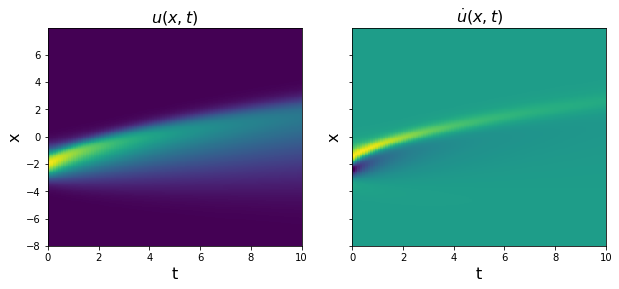

In [71]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

### PDE-FIND in PySINDy

Now, we will begin passing our data through PySINDy's PDE-FIND to recover the governing equations. I also perform this using 3 different optimizers to compare which one works best for this model. 

#### Setting up the Model 
We initialize our model using PDE Library built into PySINDy. We start off with  `derivative_order = 2` and keep the format of `function_names=library_function_names` for readability. Here's a comparison: 

\begin{itemize}
\item Without function names

```['f0(x0)', 'f0(x1)', 'f1(x0)', 'f1(x1)', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'f0(x0)x0_1', 'f0(x0)x1_1', 'f0(x1)x0_1', 'f0(x1)x1_1', 'f1(x0)x0_1', 'f1(x0)x1_1', 'f1(x1)x0_1', 'f1(x1)x1_1', 'f0(x0)x0_11', 'f0(x0)x1_11', 'f0(x1)x0_11', 'f0(x1)x1_11', 'f1(x0)x0_11', 'f1(x0)x1_11', 'f1(x1)x0_11', 'f1(x1)x1_11']```
    
\item With function names

```['x0', 'x1', 'x0x0', 'x1x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x0x0_1', 'x0x1_1', 'x1x0_1', 'x1x1_1', 'x0x0x0_1', 'x0x0x1_1', 'x1x1x0_1', 'x1x1x1_1', 'x0x0_11', 'x0x1_11', 'x1x0_11', 'x1x1_11', 'x0x0x0_11', 'x0x0x1_11', 'x1x1x0_11', 'x1x1x1_11'] ```
   
\end{itemize}

![display image](https://media1.giphy.com/media/a3DCqdn8MHBmM/giphy.gif?cid=ecf05e47wum20cpzzz53ep5fbppl0j732sqx8xgs8ezjpufm&rid=giphy.gif&ct=g)

That's a little better I guess but you get the point. you can further increase readability by adding custom function names which you will see in our outputs below

In [72]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

Now to test some optimizers! The 3 optimizers we're using are STLSQ, SR3, and a greedy algorithm SSR. These optimizers are pretty straightforward to use but there are a couple of other optimizers that may be better depending on the model. The list and description of these optimizers can be found in the feature overview for PySINDy \cite{pysindy}. 

In [73]:

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=3,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()


STLSQ model: 
(u)' = 0.100 u_11 + -1.001 uu_1
SR3 model, L0 norm: 
(u)' = 0.100 u_11 + -1.001 uu_1
SSR model: 
(u)' = 0.100 u_11 + -1.001 uu_1


![nice](https://media1.giphy.com/media/uCsL8i80SVkgU/giphy.gif?cid=ecf05e47a04kgg52m9jw4o9jvc2cgtoa8uzikgx037141xdr&rid=giphy.gif&ct=g)

That's pretty darn good. All 3 optimizers were able to discover the proper governing equation and isolate what our viscosity value of $\nu$ was. To clarify, let's compare what we started with and what the STLSQ model gave us:

Actual: $u_t = -uu_x + 0.1 u_{xx}$

Recovered: $u_t = -1.001 uu_x + 0.100 u_{xx}$

## Why Stop There?

There is one major question to ask: How well does this algorithm work? It is able to reproduce the data realitvely well but in both cases of full dataset and subsampling, PDE-FIND becomes very sensitive to noise. This is where the creation of WSINDy was made to rectify the noise issue. 

# WSINDy
By using weak SINDY, we can increase the robustness, speed, and accuracy
for discovering the governing equations of a given system. WSINDy outperforms SINDy for higher signal-to noise data. This is done by removing the need for pointwise derivative approximations in discovering the PDE. WSINDy can recover governing terms with acceptable accuracy even as the signal-to-noise ratio approaches one in certain systems . WSINDy has the added ability to achieve high-accuracy recovery in the presence of noise. \cite{messenger_2021}

WSINDy is distinguished by employing integration by parts in space and time against smooth compactly supported test functions to recover PDE’s. Exploiting the separability of test functions from the convolutional weak form enables efficient model identification in the Fast Fourier Transform (FFT). The implementation of the FFT is important in analyzing the high-noise modes in the data and determining the test function hyperpa- rameters required. WSINDy requires some manual tuning of hyperparameters to ensure proper filtering of high-frequency modes while preserving dominant behavior, allowing higher accuracy in the large-noise regime. 

## Burgers' Equation with WSINDy

Now let's impliment WSINDy to recover the Burgers' equation \ref{eq:3} from the same data that we used for PDE-FIND. This should be a no brainer since there is no major noise in the data. 

In [74]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Creating our spatiotemporal grid and then calling the weak sindy library
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )

# Model fitting using SR3
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)

#Fitting with SINDy
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, quiet=True)
model.print()

(u)' = 0.100 u_11 + -1.000 uu_1


## Noisy Data

Now lets try adding noise to the same data. 

### 20% Noise

In [75]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

#root mean squared error for use in adding noise
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 5.0, u.shape)
u = np.reshape(u, (len(x), len(t), 1))
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions, 
    function_names=library_function_names, 
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True, K=1000,
    )

optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, quiet=True)
model.print()

(u)' = 0.098 u_11 + -0.986 uu_1


With WSINDy, we were able to recover the equation $u_t = -.986 uu_x + 0.098 u_{xx}$ which is pretty darn good for 20% noise. Now let's try to break it. 

### 33% noise

In [76]:
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse /3.0, u.shape)
u = np.reshape(u, (len(x), len(t), 1))
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, quiet=True)
model.print()


(u)' = 0.069 u + -0.184 uu + 0.060 u_11 + -1.340 uu_1 + 0.771 uuu_1


Alright, this isn't looking too good but at least the terms of `u_11` and `uu_1` are somewhat correct. 

### 50% Noise

In [91]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 2.0, u.shape)
u = np.reshape(u, (len(x), len(t), 1))
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions,                            
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )

optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, quiet=True)
model.print()

(u)' = 0.049 u + -0.194 uu + 0.052 u_11 + -1.300 uu_1 + 0.644 uuu_1 + -0.006 uuu_11


This is now getting really bad compared to the 35% version where the terms we care about are now significantly off (At least the signs are correct). 

WSINDy starts to slow down when trying to retain the correct model with increase noise. This is because with increased noise, the K value has to be increased as well which severely impacts the computation time. For this reason I will leave it to the reader to mess with the K value and see if you can recover the correct equation, but beware that my PC did not like it one bit. 

Otherwise, the main Takeaway is how robust WSINDy can be made on its own. But there are other techniques that can be utilized in tandem with WSINDy to further increase its robustness to noise such as ensembling and filtering. I mentioned subsampling in the PDEFIND introduction, but a form of filtering that can be utilized is Robust principle component analysis which helps in separating noise from coherent structures in data. There is a python script that someone has made to implement RPCA into python but I was unable to properly implement it with PySINDy but I will include my tests in the Appendix. 

# PDE-FIND vs WSINDy

Now let's compare the outputs of PDE-FIND and WSINDy when recovering the Burgers' equation at the various noise levels.

## 0% Noise

This one showed that both worked pretty well for 0% noise. The outputs were:

PDE-FIND: $u_t = -1.001 uu_x + 0.100 u_{xx}$

WSINDy: $u_t = -1.00 uu_x + 0.100 u_{xx}$

With WSINDy, we were able to recover the equation and dynamics EXACTLY to the actual equation. 

## 20% Noise

We were able to recover the equation and dynamics pretty well for WSINDy, but now lets test this with PDE-FIND.

In [81]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 5.0, u.shape)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

optimizer = ps.SR3(
    threshold=3,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

(u)' = -0.133 uu + -0.001 uuu_1 + -0.543 uu_11


Now let's compare:

PDE-FIND: $u_t = -0.133 u^2 + -0.001uuu_x + -0.543 uu_{xx}$ 

WSINDy: $u_t = -.986uu_x + 0.0986 u_{xx}$ 


Here we start to see WSINDy separate from PDE-FIND. With 20% noise, PDE-FIND has recovered extra terms and lost both of our actual terms needed while WSINDy has retained its robustness to still be rounded to our original equation $u_t = -uu_x + 0.1 u_{xx}$ (\ref{eq:3})

## 33% Noise

For 33% Noise we started to see some of the noise affect the robustness of WSINDy. 

In [82]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 3.0, u.shape)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

optimizer = ps.SR3(
    threshold=3,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

(u)' = -0.100 uu + -0.002 uuu_1 + 0.004 uuu_11



PDE-FIND: $u_t = -0.100 u^2 + -0.002uuu_x + 0.004 uuu_{xx}$ 

WSINDy: $u_t = 0.069u + -0.184u^2 + 0.060u_{xx} + -1.340 uu_{x} + 0.771 u^2u_{x}$

We have gained extra terms in both model, but while WSINDy still contains $+u_{xx}$ and $-uu_{X}$ terms relatively close to what their coefficients are, PDE-FIND has lost both of those terms and the dynamics described are now not as easily seen. 


## 50% Noise

In [90]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 2.0, u.shape)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

optimizer = ps.SR3(
    threshold=3,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

(u)' = -0.109 uu + -0.001 uuu_1


Finally, comparing 50% noise we have: 


PDE-FIND: $u_t = -0.109 u^2 + -0.001uuu_x$ 

WSINDy: $u_t = 0.049u + -.194u^2 + 0.052u_{xx} + -1.300 uu_{x} + 0.644 u^2u_{x} + -.006u^2u_{xx}$

While WSINDy has picked up another extra term compared to 33%, it is still retaining the coefficients for the expected terms pretty close to the actual value. The dynamics become less clear to identify but there are plenty of techniques to help increase the robustness to a variety of different noise levels and types. 

# Tips for Robustness

From the documentation\cite{pysindy}, there are a few ways to help with the robustness and efficiency of PySINDy

## Subsampling

Subsampling/Ensembling is one of the methods to help with the robustness of the algorithm to any outliers or corrupted data. This also helps when dealing with large datasets and efficiency of analyzing the dataset when implementing with PySINDy. I was unsuccessful in implementing a working version of subsampling for my dataset so I will include an example of one in the Appendix\cite{}. 

## Optimizing the Optimizers

There are a few optimizers built-in to PySINDy that work for a variety of different use-cases and all of them can be fine-tuned to the dataset and model. I mainly focused on SR3 as it was the best optimizer for my use case but it is universally pretty powerful to start off with. The downside is the computation time as discussed in my WSINDy model where further techniques would be needed to help keep computations low while increasing robustness.

## Filtering Techniques

A very simple but powerful technique to be implemented for any data is a pre-filtering of corruption/noisy data within the measurements. This can include what is called Salt and Pepper noise (Corrupted measurements that are either null values or extreme outliers) or general Gaussian noise. One of my favorite algorithms for pre-filtering is RPCA\cite{scherl_2019} which I have only used in fluid flows but it can be used in a system to recover the coherent structure modes of a dynamics system. It has shown to have robustness of up to 60% of salt and pepper noise, though it doesn't work as well with Gaussian noise. There are other techniques such as DMD or even better regression techniques to help with the training process which will improve PySINDy's ability to recover the dynamics. 

# Results/Conclusions
There are a few conclusions that one can make from this analysis. 


## Computation
When comparing WSINDy to PDE-FIND, I have found that PDE-FIND took very little time to compute anything I threw at it. For my system, it would need only about a second with a K value as high as 1000. In contrast, WSINDy would take quite a long time with the same K value. When increasing the value to 5000, I started to notice instability in my system and long computation times with a result that had not a significant change as I would have liked. As I mentioned in the tips section, there are practices and techniques to reduce this computation for a better result but the only one I was able to successfully implement with my current system was pre-filtering with RPCA before inputting to WSINDy, though I found the reproducability to not be consistent. 

## Ease of Use
As a package, PySINDy has been great for not only learning the power of SINDy but also the ease of use for it. I feel that if I had a piece of data and just wanted to do a quick analysis of it before diving too far into a numerical analysis, I could just try to run some SINDy models to get a better picture and possibly find analytical solutions from the dynamics of the data. WSINDy requires more setup and configuration with the hyperparameters and model fitting, but that may be something that requires more experience in data-driven methods in which I am an amateur. 

## Robustness
WSINDy completely dominated PDE-FIND when it came to Gaussian noise and while the computation time mentioned above is a concern, its robustness is truly something interesting and one that I know from reading papers and documentation that when implemented with the techniques I mentioned could really have a very low margin of error with noisy data. 

# Takeaways
We were able to compare PDE-FIND and WSINDy for various noise levels when trying to recover the dynamics of a system and its governing equations from its data alone. The ability to do so in both of those methods is phenomenal for both real time computing in applications of robotics and aviation as well as research and analysis of data where the dynamics of a system may not be as simple to compute and may have multiple influences within itself. While this tutorial went over a very basic equation that is both foundational and broad, the use case for SINDy has span disciplines from biology and health to physics and fluids. I look forward to incorporating this into any future work I have and hope that you the reader may have found this interesting as well.

# Appendix 


## RPCA Analysis

In [12]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse /4 , u.shape)
rpca = R_pca(u)
L, S = rpca.fit(max_iter=10000, iter_print=100)
u = np.reshape(L, (len(x), len(t), 1))

# Define weak form PDE library 
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )

# Fit a weak form model
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, quiet=True)
model.print()

iteration: 1, error: 0.042024064235227414
iteration: 100, error: 7.094911202643978e-05
iteration: 200, error: 7.592812430941474e-05
iteration: 300, error: 0.0001517408475892644
iteration: 400, error: 6.937631591338061e-05
iteration: 500, error: 0.0002610296316000412
iteration: 600, error: 5.901187751280206e-05
iteration: 700, error: 2.704963153811015e-05
iteration: 800, error: 2.348368370092646e-05
iteration: 900, error: 3.0165120549385487e-05
iteration: 1000, error: 1.75288249425148e-05
iteration: 1100, error: 1.2745364751037722e-05
iteration: 1200, error: 1.5216646083194011e-05
iteration: 1300, error: 2.1439991946888957e-05
iteration: 1400, error: 7.0462942493448055e-06
iteration: 1500, error: 6.122215576918671e-06
iteration: 1600, error: 4.520631089777066e-06
iteration: 1700, error: 3.7959466703516555e-06
iteration: 1734, error: 3.5211637959253707e-06
(u)' = 0.108 u_11 + -0.989 uu_1


When using RPCA to pre-filter the velocity data before pushing it through WSINDy, we are actually able to recover the equation without any extra terms with 25% noise.

In [22]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse /3 , u.shape)
rpca = R_pca(u)
L, S = rpca.fit(max_iter=10000, iter_print=100)
u = np.reshape(L, (len(x), len(t), 1))

# Define weak form PDE library 
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )

# Fit a weak form model
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, quiet=True)
model.print()

iteration: 1, error: 0.0449680301746169
iteration: 100, error: 6.362683392258706e-05
iteration: 200, error: 6.442561651736265e-05
iteration: 300, error: 0.00010675743961488923
iteration: 400, error: 0.0003880924156394892
iteration: 500, error: 7.770746207782244e-05
iteration: 600, error: 0.00028732326330648444
iteration: 700, error: 3.9456975399804013e-05
iteration: 800, error: 5.0254853663377214e-05
iteration: 900, error: 2.1421042383108383e-05
iteration: 1000, error: 2.8922622009850058e-05
iteration: 1100, error: 1.4485822593975574e-05
iteration: 1200, error: 2.269802707885611e-05
iteration: 1300, error: 1.629718938606602e-05
iteration: 1400, error: 1.1881419487494385e-05
iteration: 1500, error: 8.999990166828658e-06
iteration: 1600, error: 6.362971861665705e-06
iteration: 1700, error: 9.402698354521978e-06
iteration: 1800, error: 4.198410024256279e-06
iteration: 1900, error: 3.7503736078293365e-06
iteration: 1905, error: 3.593412470093479e-06
(u)' = 0.088 u_11 + -1.459 uu_1 + 1.222 

In [78]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse /2 , u.shape)
rpca = R_pca(u)
L, S = rpca.fit(max_iter=10000, iter_print=100)
u = np.reshape(L, (len(x), len(t), 1))
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=3000,
                            )
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, quiet=True)
model.print()

iteration: 1, error: 0.05244437975849675
iteration: 100, error: 5.66111244721864e-05
iteration: 200, error: 5.802183088024086e-05
iteration: 300, error: 5.944967513911849e-05
iteration: 400, error: 5.980939290217996e-05
iteration: 500, error: 0.00011242556655937149
iteration: 600, error: 0.00012761508617138915
iteration: 700, error: 6.894238846215064e-05
iteration: 800, error: 3.870492253416376e-05
iteration: 900, error: 3.6852829490702036e-05
iteration: 1000, error: 3.505298911398232e-05
iteration: 1100, error: 2.312289036208252e-05
iteration: 1200, error: 3.26586250355548e-05
iteration: 1300, error: 1.614966336479392e-05
iteration: 1400, error: 1.9564865703099228e-05
iteration: 1500, error: 1.1246882254400325e-05
iteration: 1600, error: 0.0001006480258563549
iteration: 1700, error: 1.1176179563706866e-05
iteration: 1800, error: 7.03741881471299e-06
iteration: 1900, error: 1.277917404661396e-05
iteration: 2000, error: 5.187881029178372e-06
iteration: 2100, error: 6.196554744586589e-06

At 50% noise we lose some of the robustness but as I mentioned above, this now requires further fiddling with the library that will increase it's computation requirements. Otherwise, the computation to reach this result compared to WSINDy alone is shorter and we are able to recover a decent result of the dynamics for the system. 

## Attempt at Subsampling for Burgers' Dataset

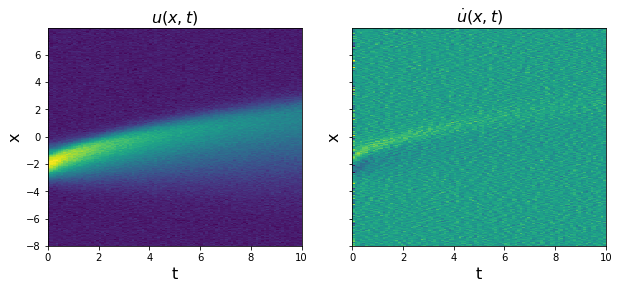

In [92]:
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 10.0, u.shape)
dt = time[1] - time[0]
dx = x[1] - x[0]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u = u.reshape(len(x), len(time), 1)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot[:, :, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [93]:
train = range(0, int(len(time) * 0.6))
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train, :]
u_test = u[:, test, :]
u_dot_train = u_dot[:, train, :]
u_dot_test = u_dot[:, test, 0]
t_train = time[train]
t_test = time[test]

X, T = np.meshgrid(x, t_train)
XT = np.asarray([X, T]).T
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    include_bias=True,
    is_uniform=False,
    periodic=True
)

In [94]:
n_models = 10
optimizer = ps.SR3(threshold=2, max_iter=100, tol=1e-3, 
                   thresholder='l0', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, ensemble=True, 
          n_models=n_models, n_subset=len(time) // 2, quiet=True)

model.print()

# Aggregate, average, and take median of the coefficients
weak_KS_models = np.asarray(model.coef_list)
mean_weak_KS_models = np.mean(weak_KS_models, axis=0)
median_weak_KS_models = np.median(weak_KS_models, axis=0)
print('Mean of KS models: ', mean_weak_KS_models)
print('Median of KS models: ', median_weak_KS_models)

(x0)' = 0.000
Mean of KS models:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Median of KS models:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [95]:
negligible_val = 1e-2

# Simple definition of a model error, ||True - Pred|| / ||True||
def model_error(KS_pred_coef, KS_true_coef):
    return np.linalg.norm(KS_true_coef - KS_pred_coef
                         ) / np.linalg.norm(KS_true_coef)

# Returns 1 if the identified model has three coefficient 
# entries in the right locations. Otherwise returns 0. 
def success_rate(KS_pred_coef, KS_true_coef):
    return np.all(
        (abs(KS_true_coef) > negligible_val) == (abs(KS_pred_coef) > negligible_val)
    )

In [96]:
print(model.get_feature_names())
KS_true = np.zeros((1, 15))
KS_true[0, 4] = -1.0
KS_true[0, 6] = -1.0
KS_true[0, 7] = -1.0
print('mean: ', model_error(mean_weak_KS_models, KS_true), 
      success_rate(mean_weak_KS_models, KS_true))
print('median: ', model_error(median_weak_KS_models, KS_true), 
      success_rate(median_weak_KS_models, KS_true))

total_model_error = []
total_success_rate = []
for i in range(n_models):
    coef = weak_KS_models[i, :, :]
    total_model_error.append(model_error(coef, KS_true))
    total_success_rate.append(success_rate(coef, KS_true))
    print(i, model_error(coef, KS_true), success_rate(coef, KS_true))
    
print('Average model error: ', np.mean(total_model_error, axis=0) * 100, '%')
print('Average success rate: ', np.mean(total_success_rate, axis=0) * 100, '%')

['1', 'x0', 'x0x0', 'x0_1', 'x0_11', 'x0_111', 'x0_1111', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11', 'x0x0_111', 'x0x0x0_111', 'x0x0_1111', 'x0x0x0_1111']
mean:  1.0 False
median:  1.0 False
0 1.0 False
1 1.0 False
2 1.0 False
3 1.0 False
4 1.0 False
5 1.0 False
6 1.0 False
7 1.0 False
8 1.0 False
9 1.0 False
Average model error:  100.0 %
Average success rate:  0.0 %


In [97]:
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    include_bias=True,
    is_uniform=True,
    K=200,
    num_pts_per_domain=200,
    include_interaction=True,
    periodic=True
)

In [98]:
cross_val_runs = 1
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    K=400,
    is_uniform=True,
    num_pts_per_domain=100,
)
optimizer = ps.SR3(
    threshold=0.5, max_iter=20, tol=1e-10, 
    thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        model.fit(u_noisy, quiet=True)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

(x0)' = 0.000


/tmp/ipykernel_437/3441022592.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
/tmp/ipykernel_437/3441022592.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
/tmp/ipykernel_437/3441022592.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)


KeyboardInterrupt: 

## Example for Subsampling using Lorenz Equation \cite{pysindy}
$$\dot x = -10x + 10y,$$
 $$ \dot y = x(28 - z) - y,$$
 $$\dot z = xy - \frac{8}{3} z.$$ 


In [100]:
from pysindy.utils.odes import lorenz

dt = .002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, 
                    t_eval=t_train, **integrator_keywords).y.T

# add 1% noise to add a little complexity 
# (otherwise all the models are basically correct)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train = x_train + np.random.normal(0, rmse / 100.0, x_train.shape)

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, 
                   t_eval=t_test, **integrator_keywords).y.T

# Instantiate and fit the SINDy model 
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
# Ensemble with replacement (V1)
model.fit(x_train, t=dt, ensemble=True, quiet=True)
model.print()
ensemble_coefs = model.coef_list

(x)' = -2.610 1 + -9.972 x + 9.939 y + 0.146 z
(y)' = 26.731 x + -0.617 y + -0.972 x z
(z)' = 2.564 1 + 0.284 x + -0.197 y + -2.762 z + 0.991 x y


In [101]:
# repeat without replacement (V2)
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, replace=False, quiet=True)
model.print()
ensemble_coefs = model.coef_list

(x)' = -9.929 x + 9.940 y
(y)' = 0.146 1 + 27.799 x + -0.927 y + -0.996 x z
(z)' = -0.113 1 + -2.657 z + 0.999 x y


# References

[<a id="cit-rpcapy" href="#call-rpcapy">1</a>] , ``_Robust-PCA_'',  .  [online](\url{https://github.com/dganguli/robust-pca})

[<a id="cit-brunton_2016" href="#call-brunton_2016">2</a>] L. Steven, L. Joshua and Nathan J., ``_Discovering governing equations from data by sparse identification of nonlinear dynamical systems_'', Proceedings of the National Academy of Sciences, vol. 113, number 15, pp. 3932--3937, mar 2016.  [online](https://doi.org/10.1073%2Fpnas.1517384113)

[<a id="cit-scherl_2019" href="#call-scherl_2019">3</a>] Isabel Scherl, Benjamin Strom, Jessica K. Shang <em>et al.</em>, ``_Robust Principal Component Analysis for Modal Decomposition of Corrupt Fluid Flows_'',  2019.  [online](https://arxiv.org/abs/1905.07062)

[<a id="cit-pysindy" href="#call-pysindy">4</a>] , ``_PySINDy_'',  .  [online](\url{https://pysindy.readthedocs.io/en/latest/index.html})

